In [ ]:
#!pip install networkx matplotlib numpy

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# --- 1. シミュレーションのパラメータ設定 ---
N = 100      # ノード数
T = 8001     # シミュレーションの総ステップ数
plot_steps = [0, 500, 1000, 2000, 4000,6000,8000]  # 意見分布を描画するステップ

# ネットワークモデルごとのパラメータ
# WS (Watts-Strogatz) モデル
k = 4
beta = 0.2
# BA (Barabasi-Albert) モデル
m = 2

In [28]:
# --- 2. ネットワークの生成 ---
ws_graph = nx.watts_strogatz_graph(N, k, beta, seed=42)
ba_graph = nx.barabasi_albert_graph(N, m, seed=42)


# 生成したグラフを辞書に格納 (WSとBAのみ)
graphs = {
    "WS Model": ws_graph,
    "BA Model": ba_graph,
}

logging.info(f"ネットワークの生成完了\nノード数:{N}")

2025-06-09 21:30:01,050 - INFO - ネットワークの生成完了
ノード数:100


In [29]:
def simulate(graph, model_type, total_steps):
    """
    指定されたネットワークとモデルで意見ダイナミクスのシミュレーションを実行する関数。

    Args:
        graph (nx.Graph): シミュレーションを行うネットワークグラフ。
        model_type (str): 'majority' または 'voter' を指定。
        total_steps (int): シミュレーションの総ステップ数。

    Returns:
        tuple: (平均意見のリスト, 各描画ステップでの意見分布の辞書)
    """
    # 初期意見を-1か1でランダムに割り当て
    opinions = {i: random.choice([-1, 1]) for i in graph.nodes()}
    
    avg_opinions_history = [np.mean(list(opinions.values()))]
    opinions_snapshot = {0: opinions.copy()} # ステップ0の初期状態を保存

    for t in range(1, total_steps):
        # ランダムにノードを1つ選択
        node = random.choice(list(graph.nodes()))
        neighbors = list(graph.neighbors(node))

        # 隣人がいないノードはスキップ
        if not neighbors:
            avg_opinions_history.append(np.mean(list(opinions.values())))
            continue

        # ----- モデルごとの意見更新ルール -----
        if model_type == 'majority':
            # 多数派モデル: 隣人の意見の多数派に合わせる
            neighbor_opinions = [opinions[n] for n in neighbors]
            opinion_sum = sum(neighbor_opinions)
            if opinion_sum > 0:
                opinions[node] = 1
            elif opinion_sum < 0:
                opinions[node] = -1
            # 意見が同数の場合は現状維持

        elif model_type == 'voter':
            # Voterモデル: ランダムに選んだ隣人1人の意見に合わせる
            random_neighbor = random.choice(neighbors)
            opinions[node] = opinions[random_neighbor]

        # 各ステップの平均意見を記録
        avg_opinions_history.append(np.mean(list(opinions.values())))
        
        # 指定したステップの意見分布を保存
        if t in plot_steps:
            opinions_snapshot[t] = opinions.copy()
            
    return avg_opinions_history, opinions_snapshot

In [30]:
# --- 4. 全ての組み合わせでシミュレーションを実行 ---
results = {}
for g_name, graph in graphs.items():
    for model_name in ['majority', 'voter']:
        logging.info(f"  Simulating {model_name.capitalize()} on {g_name}...")
        avg_opinions, opinions_history = simulate(graph, model_name, T)
        results[(g_name, model_name)] = {
            "avg_opinions": avg_opinions,
            "opinions_history": opinions_history,
        }
logging.info("Simulations finished.")

2025-06-09 21:30:01,855 - INFO -   Simulating Majority on WS Model...
2025-06-09 21:30:01,913 - INFO -   Simulating Voter on WS Model...
2025-06-09 21:30:01,965 - INFO -   Simulating Majority on BA Model...
2025-06-09 21:30:02,018 - INFO -   Simulating Voter on BA Model...
2025-06-09 21:30:02,068 - INFO - Simulations finished.


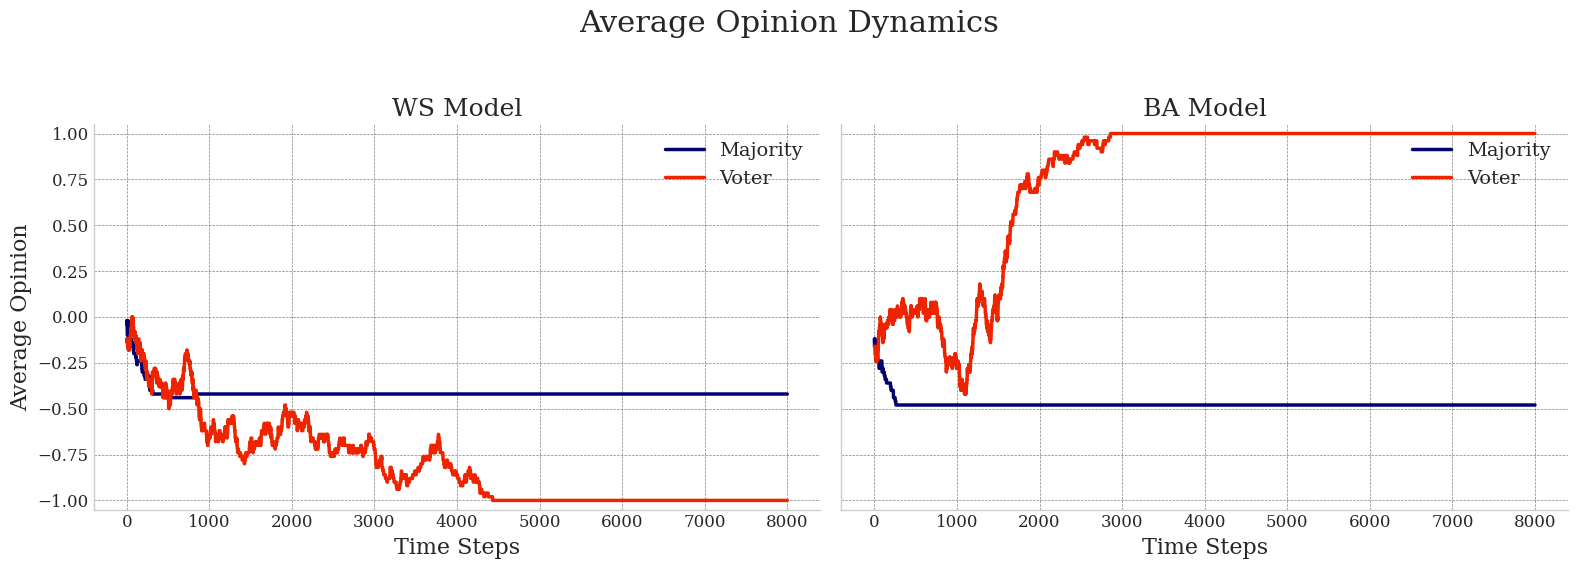

In [35]:
plt.style.use('seaborn-v0_8-whitegrid')
# フォントサイズやフォントファミリーをより詳細に設定
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
})

fig_avg, axes_avg = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig_avg.suptitle("Average Opinion Dynamics", fontsize=22)

# 色と線のスタイルを定義
colors = {'majority': '#01016f', 'voter': '#ee2400'} # カラーブラインドフレンドリーな青とオレンジ
linestyles = {'majority': '-', 'voter': '-'}
linewidth = 2.5

for i, (g_name, graph) in enumerate(graphs.items()):
    ax = axes_avg[i]
    
    # モデルごとにプロット
    for model_name in ['majority', 'voter']:
        data = results[(g_name, model_name)]
        ax.plot(
            data["avg_opinions"],
            label=model_name.capitalize(),
            linestyle=linestyles[model_name],
            color=colors[model_name],
            linewidth=linewidth
        )
        
    # --- プロットの装飾 ---
    ax.set_title(g_name)
    ax.set_xlabel("Time Steps")
    ax.set_ylim(-1.05, 1.05)
    
    # 凡例を枠なしで表示
    ax.legend(frameon=False)
    
    # 上と右の枠線を非表示にする
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')

# Y軸のラベルを中央に設定
axes_avg[0].set_ylabel("Average Opinion")

# レイアウトを調整
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

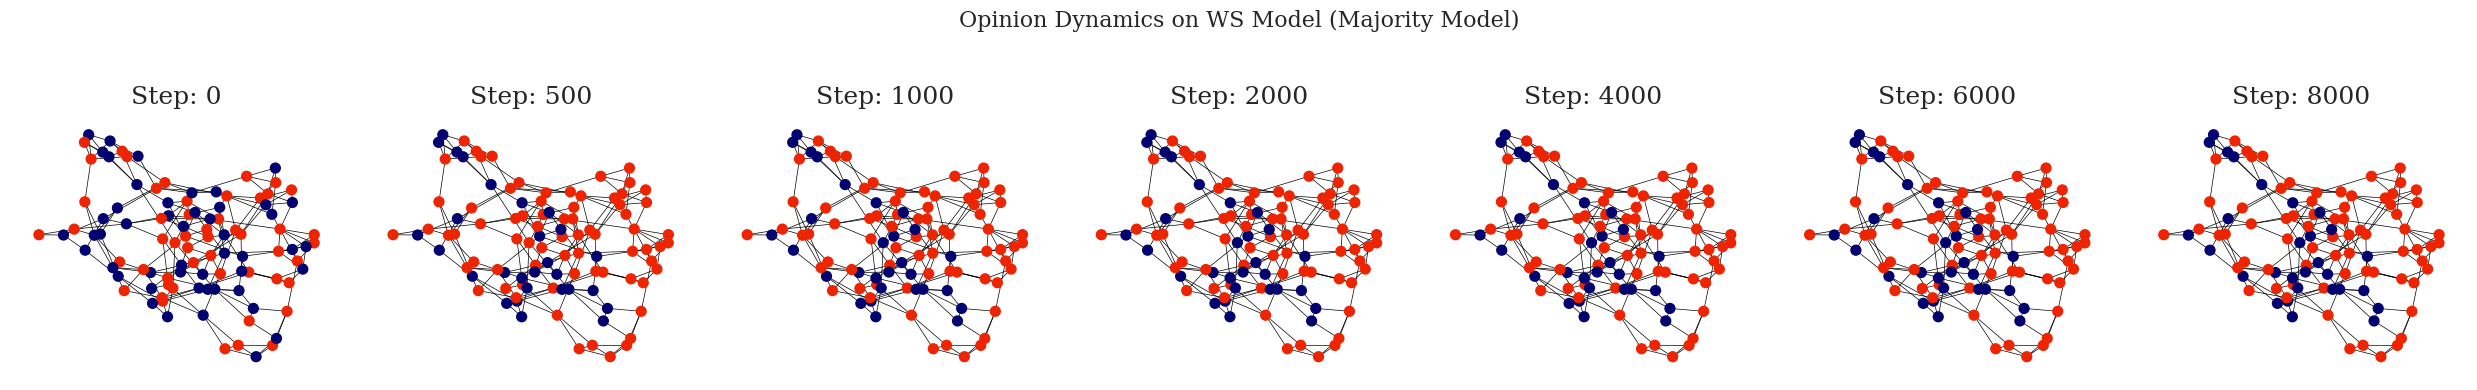

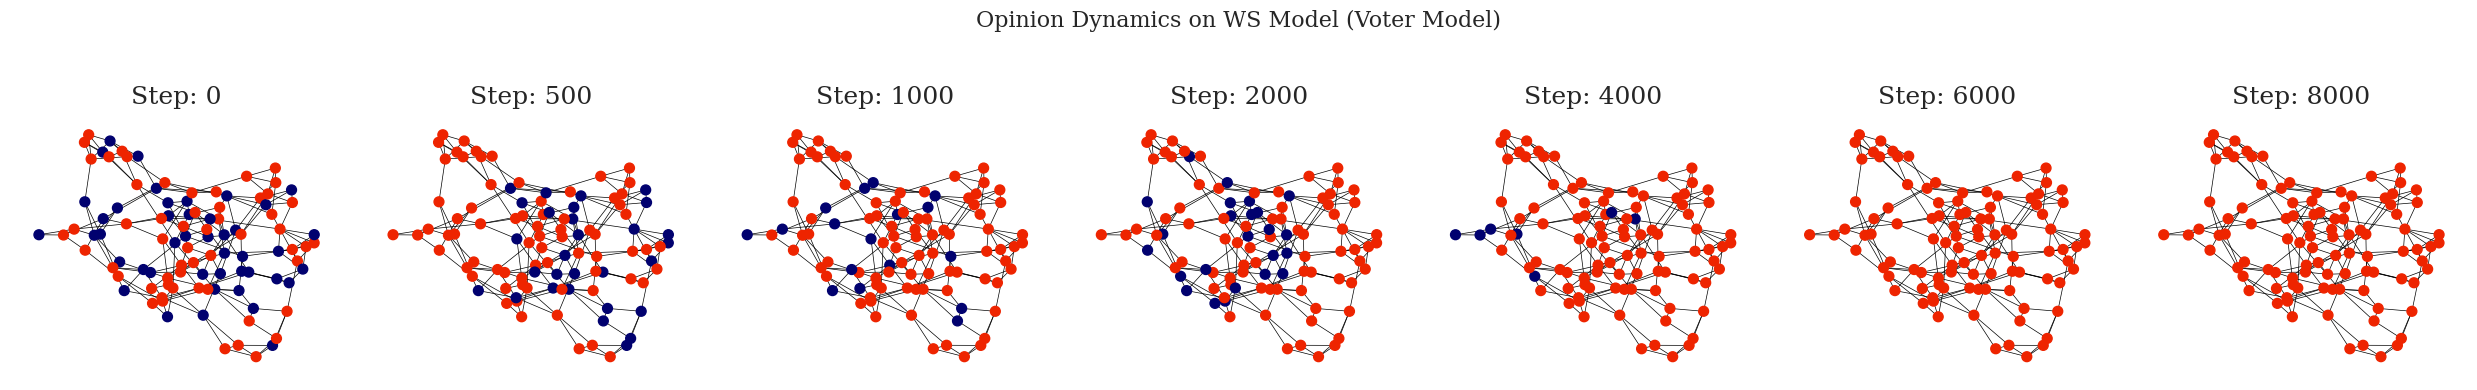

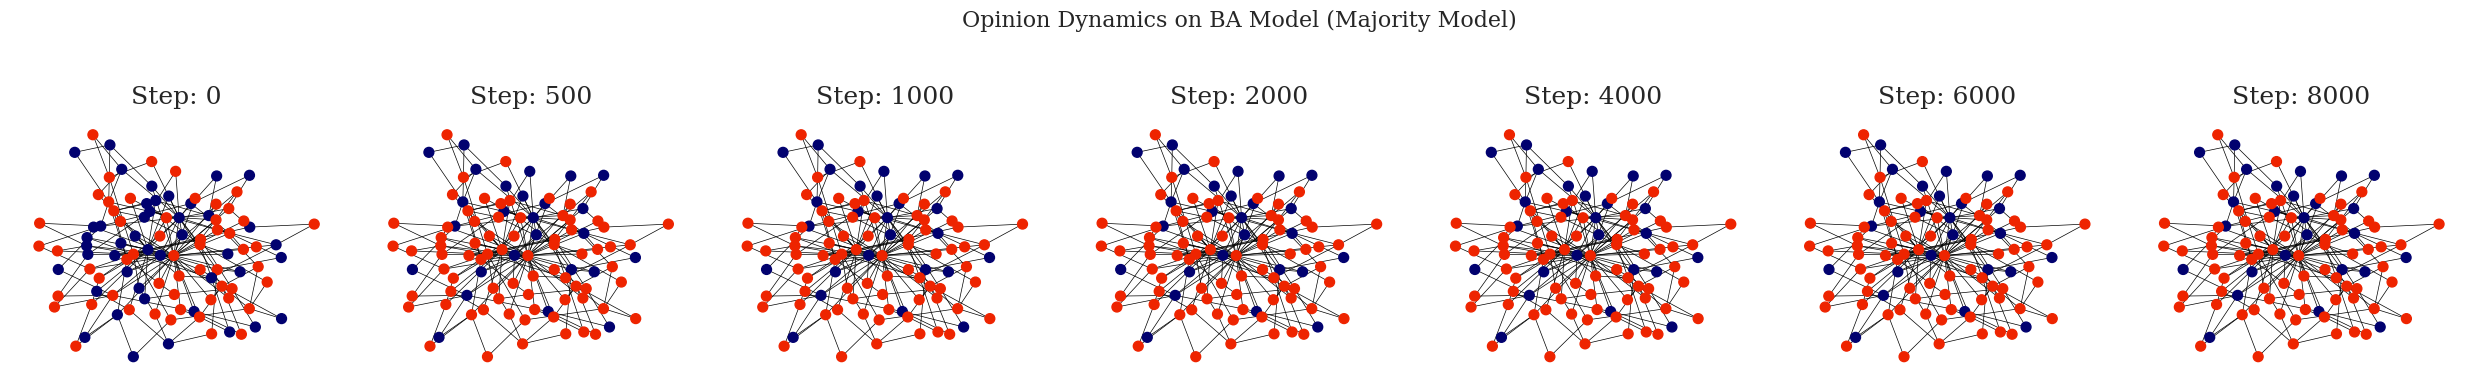

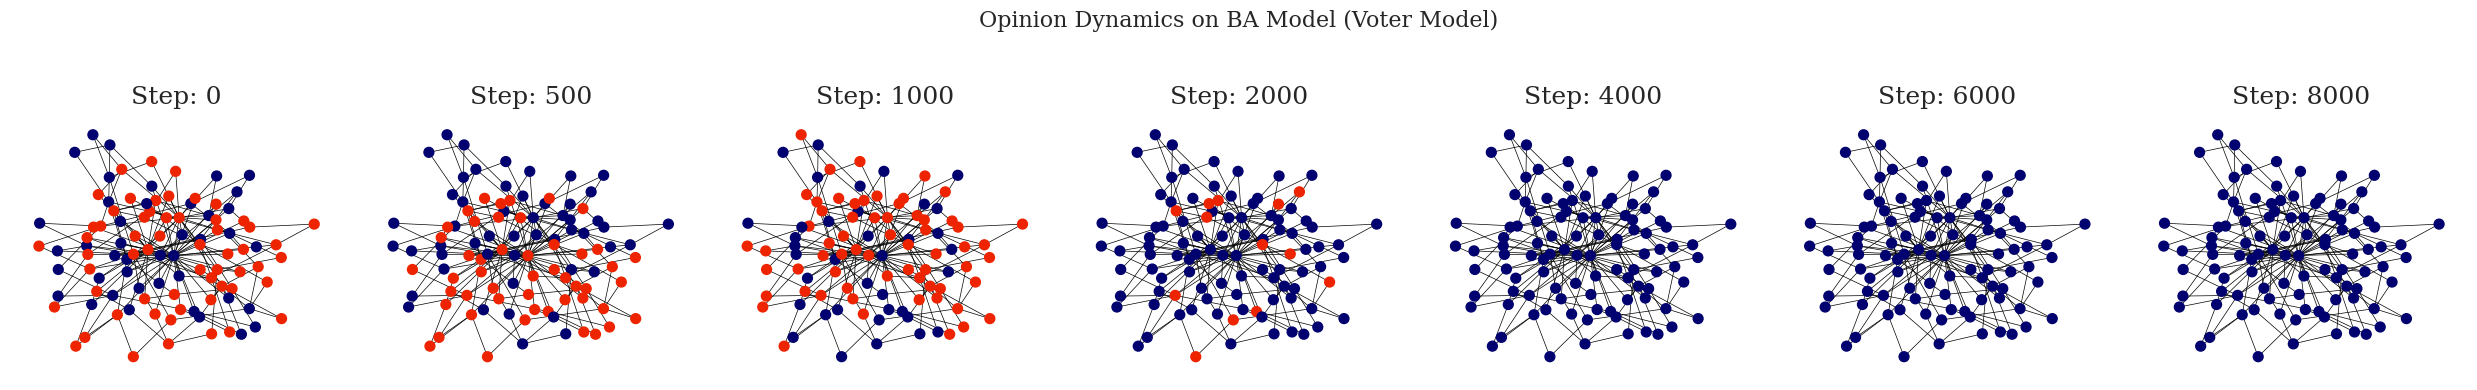

In [36]:
# 5.2. ステップごとの意見分布をプロット
for g_name, graph in graphs.items():
    for model_name in ['majority', 'voter']:
        fig, axes = plt.subplots(1, len(plot_steps), figsize=(25, 4))
        fig.suptitle(f"Opinion Dynamics on {g_name} ({model_name.capitalize()} Model)", fontsize=16)
        
        opinions_history = results[(g_name, model_name)]["opinions_history"]
        pos = nx.spring_layout(graph, seed=42) # ノードの配置を固定

        for i, step in enumerate(plot_steps):
            ax = axes[i]
            opinions = opinions_history[step]

            node_colors = ['#01016f' if opinions[n] == 1 else '#ee2400' for n in graph.nodes()]
            
            nx.draw(
                graph, pos, ax=ax, node_size=50,
                node_color=node_colors, with_labels=False,
                width=0.5
            )
            ax.set_title(f"Step: {step}")
            
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
# 